# Experiments in Modeling Token Frequency in Texts as Wave Signals

## Load Libraries and Utility Functions

In [1]:
import os
import re
import pandas as pd
from tqdm import tqdm
import altair as alt
alt.data_transformers.disable_max_rows()
from collections import deque
import warnings
warnings.filterwarnings('ignore')
from rich.console import Console
from rich.table import Table
import numpy as np
from scipy.fft import fft
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import pywt
import matplotlib.pyplot as plt
console = Console()
import sys

sys.path.append("..")
from segmentation_scripts.utils import read_csv_file, get_data_directory_path

In [32]:
def generate_table(df, table_title):
    # Create a Rich Table
    table = Table(title=table_title)
    columns = df.columns

    # Calculate the maximum width for each column
    max_widths = {column: max(len(str(value)) for value in df[column].astype(str)) for column in columns}

    for column in columns:
        table.add_column(column.replace("_", " ").capitalize(), justify="center", style="cyan", no_wrap=False, width=max_widths[column] + 2)

    # Add rows to the table
    for _, row in df.iterrows():
        table.add_row(*[str(value) if pd.notna(value) else "" for value in row])

    # Print the table
    console.print(table)

In [3]:
def filter_integers(token: str) -> bool:
	"""Check if the token is an integer."""
	return bool(re.match(r'^\d+$', token))

def calculate_digit_coverage(rows):
    """Calculate the number of digits in the given rows."""
    number_of_digits = rows['implied_zero'].notna().sum()
    return number_of_digits

def clean_digits(df: pd.DataFrame) -> pd.DataFrame:
	"""Clean and filter digit tokens in the DataFrame while retaining non-digit pages."""
	max_possible_number = df.page_number.max()
	
	df['token'] = df['token'].astype(str)
	if 'volume_name' in df.columns:
		df['volume_number'] = df['volume_number'].fillna(0)
	
	# Identify pages with digit tokens
	subset_digits = df[df['token'].str.isdigit()].copy()
	possible_pages = subset_digits[subset_digits['token'].apply(filter_integers)].copy()
	# Use the smaller subset if possible_pages is smaller
	console.print(f"Number of possible pages {len(possible_pages)} vs subset_digits {len(subset_digits)}")
	if len(possible_pages) < len(subset_digits):
		subset_digits = possible_pages

	# Identify pages without digit tokens
	non_digits_pages = df[(~df['token'].str.isdigit()) & (~df.page_number.isin(subset_digits.page_number))].copy()
	
	# just take the first page of non_digits_pages
	non_digits_pages = non_digits_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume: {len(subset_digits)}")
	console.print(f"Number of non-digit pages in this volume: {len(non_digits_pages)}")
	
	subset_digits['number'] = subset_digits['token'].astype(int, errors='ignore')
	# max_possible_number = max_page + 25
	filtered_subset_digits = subset_digits[(subset_digits['number'] < max_possible_number) & (subset_digits['number'] <= subset_digits.page_number)].copy()
	non_filtered_subset_digits = subset_digits[(subset_digits['number'] >= max_possible_number) & (~subset_digits.page_number.isin(filtered_subset_digits.page_number))].groupby('page_number').first().reset_index()
	console.print(f"Number of digits in this volume after filtering for max page length: {len(filtered_subset_digits)}")
	console.print(f"Number of pages without digits in this volume after filtering for max page length: {len(non_filtered_subset_digits)}")
	
	# Calculate implied zero only for digit pages
	filtered_subset_digits['implied_zero'] = filtered_subset_digits['page_number'].astype(int) - filtered_subset_digits['number']
	
	final_subset_digits = filtered_subset_digits[filtered_subset_digits['implied_zero'] >= 0]
	console.print(f"Number of digits in this volume after filtering for max page length and implied zero: {len(final_subset_digits)}")
	remaining_missing_pages = df[(~df.page_number.isin(final_subset_digits.page_number)) & (~df.page_number.isin(non_digits_pages.page_number))].copy()
	remaining_missing_pages = remaining_missing_pages.groupby('page_number').first().reset_index()
	console.print(f"Number of pages without digits in this volume after filtering for max page length and digit pages: {len(remaining_missing_pages)}")
	
	# Merge non-digit pages back into the DataFrame
	non_digits_pages['page_type'] = 'non_digit'
	remaining_missing_pages['page_type'] = 'negative_na_digit'
	final_subset_digits['page_type'] = 'digit'
	non_filtered_subset_digits['page_type'] = 'digit_too_large'
	full_df_with_digits = pd.concat([final_subset_digits, non_digits_pages, remaining_missing_pages, non_filtered_subset_digits]).sort_values(by=['page_number']).reset_index(drop=True)
	
	console.print(f"Number of pages after including non-digit pages: {full_df_with_digits.page_number.nunique()}")

	if full_df_with_digits.page_number.nunique() != df.page_number.nunique():
		added_pages = df[~df.page_number.isin(full_df_with_digits.page_number)].copy()
		added_pages = added_pages.groupby('page_number').first().reset_index()
		added_pages['page_type'] = 'added'
		full_df_with_digits = pd.concat([full_df_with_digits, added_pages]).sort_values(by=['page_number']).reset_index(drop=True)
		console.print(f"Number of pages after including added pages: {full_df_with_digits.page_number.nunique()}")

	# Calculate the number of digits per page
	tqdm.pandas(desc="Calculating digits per page")
	digits_per_page = full_df_with_digits.groupby('page_number').progress_apply(calculate_digit_coverage).reset_index(name='digits_per_page')
	full_df_with_digits = full_df_with_digits.merge(digits_per_page, on='page_number', how='left')
	
	return full_df_with_digits

In [4]:
def process_file(file_path: str, is_preidentified_periodical: bool):
	full_df = read_csv_file(file_path)
	console.print(f"Volume has this many tokens: {len(full_df)}")
	if is_preidentified_periodical:
		console.print(f"Volume has this many issues: {full_df.start_issue.nunique()}")
		console.print(f"Volume has this many pages: {full_df.page_number.nunique()}")
	# Factorize the 'issue_number' column to create 'actual_issue_number'
	full_df = full_df.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		full_df = full_df.rename(columns={'issue_number': 'original_issue_number', 'page_number': 'original_page_number'})
		full_df['temp_issue_number'] = pd.factorize(full_df['original_issue_number'])[0]

	else:
		full_df = full_df.rename(columns={'page_number': 'original_page_number'})
	# Factorize the 'original_page_number' column
	factorized_values, unique_values = pd.factorize(full_df['original_page_number'])

	# Adjust the factorized values to start at 1
	full_df['page_number'] = factorized_values + 1
	# Expand count column
	expanded_df = full_df.loc[full_df.index.repeat(full_df['count'])].reset_index(drop=True)
	console.print(f"Expanded volume has this many tokens: {len(expanded_df)}")

	# Calculate the number of tokens per page
	tokens_per_page = expanded_df.groupby('page_number').size().reset_index(name='tokens_per_page')

	# Merge the token counts back into the original DataFrame
	expanded_df = expanded_df.merge(tokens_per_page, on='page_number', how='left')
	missing_pages = full_df[~full_df.page_number.isin(expanded_df.page_number.unique())]
	expanded_df = pd.concat([expanded_df, missing_pages], ignore_index=True)
	expanded_df = expanded_df.reset_index(drop=True)

	if is_preidentified_periodical:
		annotated_df = full_df[['page_number', 'start_issue', 'end_issue', 'type_of_page']].drop_duplicates()

		# Group by 'start_issue' and aggregate
		grouped_df = annotated_df.groupby('start_issue').agg(
			first_page=('page_number', 'min'),
			last_page=('page_number', 'max'),
			number_of_pages=('page_number', 'count')
		).reset_index()
		grouped_df = grouped_df.sort_values(by='first_page')

		generate_table(grouped_df, "Grouped by 'start_issue'")
	else:
		grouped_df = pd.DataFrame()

	# Example usage
	subset_digits = clean_digits(expanded_df)
	subset_digits = subset_digits.sort_values(by=['page_number'])

	if is_preidentified_periodical:
		counts_per_annotated_issue = subset_digits.start_issue.value_counts().reset_index()

		generate_table(counts_per_annotated_issue, "Counts per Annotated Issue")
	return expanded_df, subset_digits, grouped_df

	

In [5]:
matching_files = []
for directory, _, files in tqdm(os.walk("../datasets/annotated_ht_ef_datasets/"), desc="Counting matching files"):
	for file in files:
		if file.endswith(".csv") and 'individual' in file:
			if os.path.exists(os.path.join(directory, file)):
				publication_name = directory.split("/")[-2]
				volume_number = directory.split("/")[-1]
				matching_files.append({"file": file, "directory": directory, "file_path": os.path.join(directory, file), "periodical_title": publication_name, "volume_directory": volume_number})
matching_files_df = pd.DataFrame(matching_files)
console.print(f"Found {len(matching_files_df)} matching files.", style="bright_green")

Counting matching files: 0it [00:00, ?it/s]

Counting matching files: 95it [00:00, 14161.89it/s]


Found 85 matching files.

In [6]:
file_path = matching_files_df[matching_files_df.volume_directory.str.contains("053")]['file_path'].values[0]
preidentified_periodical = True

## Analyze the Waveforms of the Volume Data

Volume has this many tokens: 191668

Volume has this many issues: 12

Volume has this many pages: 616

Expanded volume has this many tokens: 407179

       Grouped by 'start_issue'        
┏━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┓
┃              ┃       ┃       ┃ Num… ┃
┃              ┃ First ┃ Last  ┃  of  ┃
┃ Start issue  ┃ page  ┃ page  ┃ pag… ┃
┡━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━┩
│  1966-07-04  │   1   │  53   │  53  │
│  1966-07-11  │  54   │  107  │  54  │
│  1966-07-18  │  108  │  160  │  53  │
│  1966-07-25  │  161  │  216  │  56  │
│  1966-08-01  │  217  │  262  │  46  │
│  1966-08-08  │  263  │  317  │  55  │
│  1966-08-15  │  318  │  373  │  56  │
│  1966-08-22  │  374  │  425  │  52  │
│  1966-08-29  │  426  │  481  │  56  │
│  1966-09-05  │  482  │  536  │  55  │
│  1966-09-12  │  537  │  591  │  55  │
│  1966-09-26  │  592  │  616  │  25  │
└──────────────┴───────┴───────┴──────┘

Number of possible pages 3558 vs subset_digits 3558

Number of digits in this volume: 3558

Number of non-digit pages in this volume: 100

Number of digits in this volume after filtering for max page length: 2196

Number of pages without digits in this volume after filtering for max page length: 25

Number of digits in this volume after filtering for max page length and implied zero: 2196

Number of pages without digits in this volume after filtering for max page length and digit pages: 27

Number of pages after including non-digit pages: 616

Calculating digits per page: 100%|██████████| 616/616 [00:00<00:00, 21697.83it/s]


  Counts per Annotated  
         Issue          
┏━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Start issue  ┃ Count ┃
┡━━━━━━━━━━━━━━╇━━━━━━━┩
│  1966-08-22  │  274  │
│  1966-07-25  │  272  │
│  1966-08-01  │  255  │
│  1966-08-29  │  245  │
│  1966-09-12  │  211  │
│  1966-08-08  │  206  │
│  1966-08-15  │  197  │
│  1966-09-05  │  188  │
│  1966-07-18  │  153  │
│  1966-07-11  │  151  │
│  1966-07-04  │  115  │
│  1966-09-26  │  81   │
└──────────────┴───────┘

Likely issue length from tokens autocorrelation: 1

Dominant Frequency: 0.03733766233766234

Number of pages marked as likely covers: 160

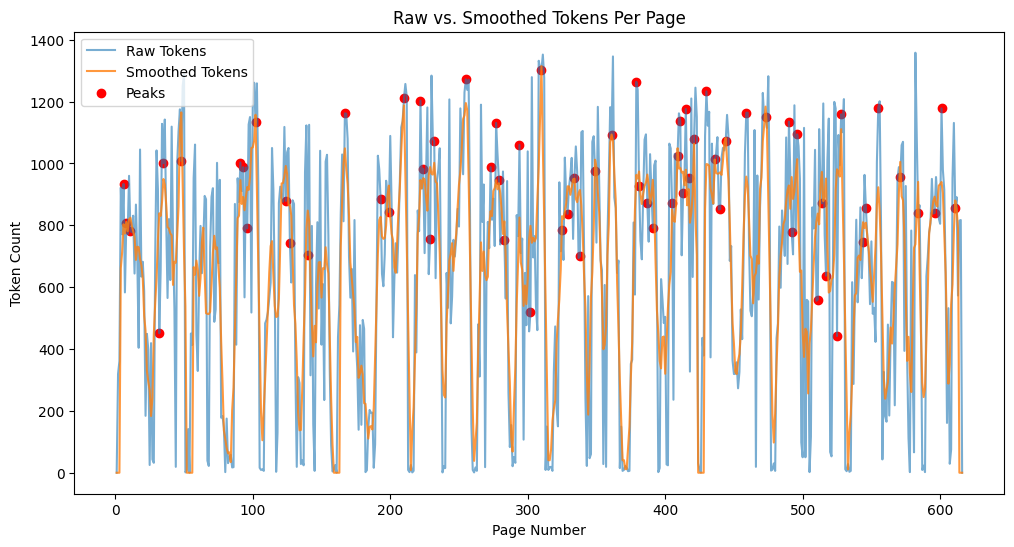

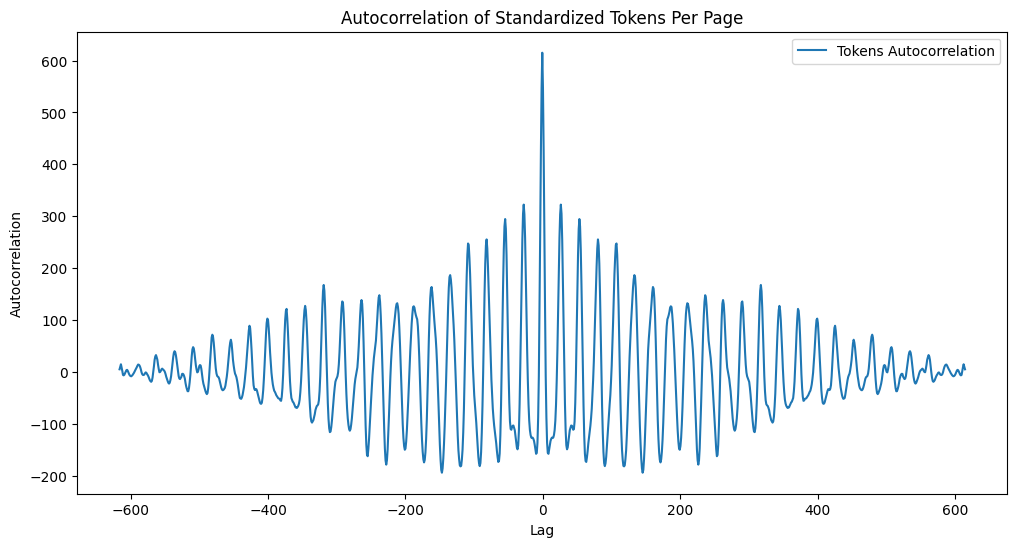

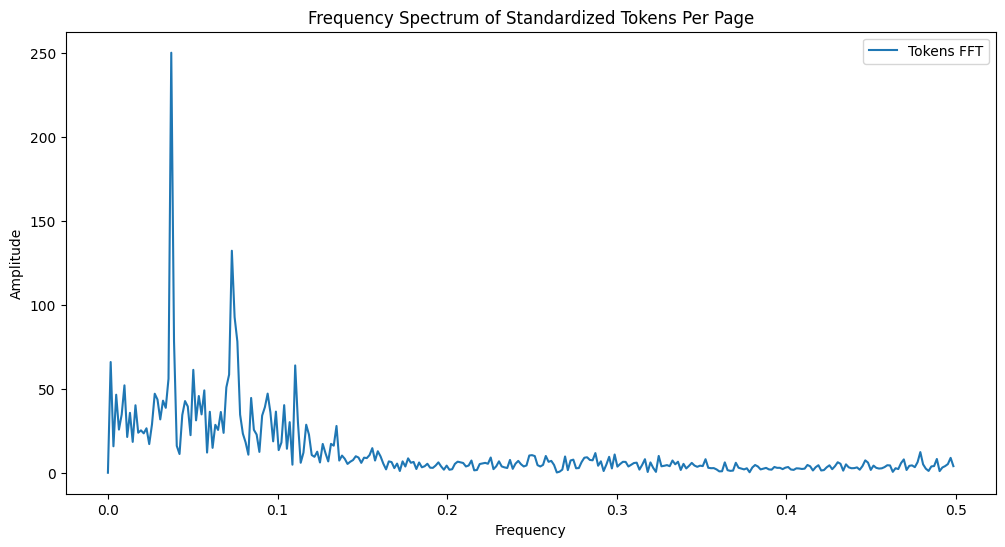

Volume Features:
{
    'avg_tokens': 661.0048701298701,
    'dominant_frequency': 0.03733766233766234,
    'issue_length': 1,
    'htid': 'inu.32000013025053',
    'periodical_name': 'Arab Observer and The Scribe'
}

In [34]:
# --- Data Processing and Preparation ---
expanded_df, subset_digits, grouped_df = process_file(file_path, is_preidentified_periodical=preidentified_periodical)

# Minimal columns needed for analysis
subset_expanded_df = expanded_df[['page_number', 'tokens_per_page', 'original_page_number', 'htid', 'title', 'pub_date', 'enumeration_chronology',
	'type_of_resource', 'title', 'date_created', 'pub_date', 'language',
	'access_profile', 'isbn', 'issn', 'lccn', 'oclc', 'page_count',
	'feature_schema_version', 'access_rights', 'alternate_title',
	'category', 'genre_ld', 'genre', 'contributor_ld', 'contributor',
	'handle_url', 'source_institution_ld', 'source_institution', 'lcc',
	'type', 'is_part_of', 'last_rights_update_date', 'pub_place_ld',
	'pub_place', 'main_entity_of_page', 'publisher_ld', 'publisher',
	'lowercase_periodical_name', 'publication_directory',
	'volume_directory', 'record_url', 'periodical_name',]].drop_duplicates()
min_subset_digits = subset_digits[['original_page_number', 'digits_per_page', 'page_number']].drop_duplicates()

# Merge and fill NaNs
merged_df = subset_expanded_df.merge(min_subset_digits, on=['original_page_number', 'page_number'], how='left')
merged_df['tokens_per_page'] = merged_df['tokens_per_page'].fillna(0)
merged_df['digits_per_page'] = merged_df['digits_per_page'].fillna(0)
merged_df = merged_df.sort_values(by='page_number')
# Apply smoothing (moving average)
merged_df['smoothed_tokens_per_page'] = (
    merged_df['tokens_per_page']
    .where(merged_df['tokens_per_page'] > 0)
    .rolling(window=5, center=True)
    .mean()
    .fillna(0)
)

merged_df['smoothed_digits_per_page'] = (
    merged_df['digits_per_page']
    .where(merged_df['digits_per_page'] > 0)
    .rolling(window=5, center=True)
    .mean()
    .fillna(0)
)

# Standardize smoothed signals
merged_df['standardized_tokens_per_page'] = (
    (merged_df['smoothed_tokens_per_page'] - merged_df['smoothed_tokens_per_page'].mean()) 
    / merged_df['smoothed_tokens_per_page'].std()
)

merged_df['standardized_digits_per_page'] = (
    (merged_df['smoothed_digits_per_page'] - merged_df['smoothed_digits_per_page'].mean()) 
    / merged_df['smoothed_digits_per_page'].std()
)

# --- Autocorrelation Analysis for Issue Length ---
tokens_autocorr = np.correlate(merged_df['standardized_tokens_per_page'].values, 
                               merged_df['standardized_tokens_per_page'].values, mode='full')

# Find dominant lag (likely issue length)
tokens_autocorr_lag = np.argmax(tokens_autocorr[len(tokens_autocorr) // 2 + 1:]) + 1
console.print(f"Likely issue length from tokens autocorrelation: {tokens_autocorr_lag}", style="bright_green")

# --- Peak Detection (Standardized Tokens) ---
token_peaks, _ = find_peaks(merged_df['standardized_tokens_per_page'], height=0.5)
merged_df['is_token_peak'] = 0
merged_df.loc[token_peaks, 'is_token_peak'] = 1

# --- FFT for Frequency Analysis ---
tokens_fft_input = merged_df['standardized_tokens_per_page'].values - np.mean(merged_df['standardized_tokens_per_page'].values)
tokens_fft = fft(tokens_fft_input)
frequencies = np.fft.fftfreq(len(tokens_fft))

dominant_frequency_index = np.argmax(np.abs(tokens_fft[1:len(frequencies)//2])) + 1
dominant_frequency = abs(frequencies[dominant_frequency_index])
console.print(f"Dominant Frequency: {dominant_frequency}", style="bright_green")

# Detect likely covers based on low standardized tokens and digits
merged_df['is_likely_cover'] = (
    (merged_df['standardized_tokens_per_page'] < -0.5) &  # Threshold for low token counts
    (merged_df['standardized_digits_per_page'] < -0.5)    # Threshold for low digit counts
)

# Summary of likely covers
num_covers = merged_df['is_likely_cover'].sum()
console.print(f"Number of pages marked as likely covers: {num_covers}", style="bright_green")

# --- Visualization ---
# Raw vs Smoothed Tokens
plt.figure(figsize=(12, 6))
plt.plot(merged_df['page_number'], merged_df['tokens_per_page'], label='Raw Tokens', alpha=0.6)
plt.plot(merged_df['page_number'], merged_df['smoothed_tokens_per_page'], label='Smoothed Tokens', alpha=0.8)
plt.scatter(merged_df['page_number'].iloc[token_peaks], merged_df['tokens_per_page'].iloc[token_peaks], color='red', label='Peaks')
plt.title("Raw vs. Smoothed Tokens Per Page")
plt.xlabel("Page Number")
plt.ylabel("Token Count")
plt.legend()
plt.show()

# Autocorrelation Plot
lags = np.arange(-len(tokens_autocorr) // 2, len(tokens_autocorr) // 2)
plt.figure(figsize=(12, 6))
plt.plot(lags, tokens_autocorr, label='Tokens Autocorrelation')
plt.title("Autocorrelation of Standardized Tokens Per Page")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

# Frequency Analysis Plot
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(tokens_fft[:len(frequencies)//2]), label='Tokens FFT')
plt.title("Frequency Spectrum of Standardized Tokens Per Page")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# --- Aggregated Features ---
volume_features = {
    'avg_tokens': merged_df['tokens_per_page'].mean(),
    'dominant_frequency': dominant_frequency,
    'issue_length': tokens_autocorr_lag,
    'htid': merged_df['htid'].unique()[0],
    'periodical_name': merged_df['periodical_name'].unique()[0]
}

console.print("Volume Features:", volume_features)

In [45]:
# Function to compute Energy-to-Entropy Ratio
def energy_entropy_ratio(signal, wavelet, level, mode='symmetric'):
	"""
	Compute energy-to-entropy ratio for wavelet coefficients.

	Parameters:
	-----------
	signal : np.ndarray
		Input signal.
	wavelet : str
		Wavelet name.
	level : int
		Decomposition level.
	mode : str
		Signal extension mode.

	Returns:
	--------
	ratio : float
		Energy-to-entropy ratio.
	"""
	coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
	energy = [np.sum(np.square(c)) for c in coeffs]
	total_energy = np.sum(energy)
	entropy = -np.sum([e / total_energy * np.log2(e / total_energy) for e in energy if e > 0])
	return total_energy / entropy

# Function to calculate Sparsity
def sparsity_measure(coeffs, threshold=1e-3):
	"""
	Measure sparsity of wavelet coefficients.

	Parameters:
	-----------
	coeffs : list of np.ndarray
		Wavelet decomposition coefficients.

	Returns:
	--------
	sparsity : float
		Percentage of near-zero coefficients.
	"""
	total_coeffs = np.concatenate(coeffs)
	sparsity = np.sum(np.abs(total_coeffs) < threshold) / len(total_coeffs)
	return sparsity

# Main Function to Evaluate Wavelet Performance

# Wavelet Performance Evaluation Function
def evaluate_wavelet_performance(signal, wavelets, modes, signal_type):
    """
    Evaluate wavelet decomposition using MSE, energy-to-entropy ratio, and sparsity for a given signal type.

    Parameters:
    -----------
    signal : np.ndarray
        Signal to analyze (raw or smoothed tokens).
    wavelets : list of str
        List of wavelet names to test.
    modes : list of str
        List of signal extension modes to test.
    signal_type : str
        The type of signal being analyzed ('raw' or 'smoothed').

    Returns:
    --------
    pd.DataFrame
        Results for wavelet analysis.
    """
    results = []

    for wavelet in tqdm(wavelets, desc=f"Testing Wavelets for {signal_type}"):
        try:
            max_level = pywt.dwt_max_level(len(signal), filter_len=wavelet)
            for level in range(1, max_level + 1):
                for mode in modes:
                    try:
                        coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
                        reconstructed_signal = pywt.waverec(coeffs, wavelet, mode=mode)[:len(signal)]

                        # Metrics
                        mse = np.mean((signal - reconstructed_signal) ** 2)
                        energy_entropy = energy_entropy_ratio(coeffs, wavelet, level, mode)
                        sparsity = sparsity_measure(coeffs)

                        # Append Results
                        results.append({
                            'signal_type': signal_type,
                            'wavelet': wavelet,
                            'wavelet_level': level,
                            'wavelet_mode': mode,
                            'wavelet_mse': mse,
                            'wavelet_energy_entropy': energy_entropy,
                            'wavelet_sparsity': sparsity
                        })
                    except ValueError:
                        pass
        except Exception as e:
            print(f"Error testing wavelet {wavelet}: {e}")

    return pd.DataFrame(results)

# Parameters
weights = {'wavelet_mse': 0.5, 'wavelet_energy_entropy': 0.3, 'wavelet_sparsity': 0.2}
wavelets = ['db4', 'haar', 'sym4', 'coif5', 'bior2.2']
modes = ['symmetric', 'periodization', 'constant']

# Signals
raw_signal = merged_df['tokens_per_page'].values
smoothed_signal = merged_df['smoothed_tokens_per_page'].values

# Evaluate Wavelet Performance
raw_results = evaluate_wavelet_performance(raw_signal, wavelets, modes, 'raw')
smoothed_results = evaluate_wavelet_performance(smoothed_signal, wavelets, modes, 'smoothed')

Testing Wavelets for smoothed: 100%|██████████| 5/5 [00:00<00:00, 952.56it/s]


In [68]:
def determine_best_representation(results_df, weights, is_combined=False):
	"""
	Normalize and rank wavelet metrics, with an option to handle combined results.

	Parameters:
	-----------
	results_df : pd.DataFrame
		DataFrame containing wavelet metrics.
	weights : dict
		Weights for MSE, Energy-to-Entropy, and Sparsity.
	is_combined : bool, optional
		If True, prefixes column names with 'combined_'.

	Returns:
	--------
	tuple:
		- best_config : pd.DataFrame
		  Best wavelet configuration.
		- ranked_results : pd.DataFrame
		  Ranked results with normalized metrics.
	"""
	# Normalize metrics
	scaler = MinMaxScaler()
	normalized_df = results_df.copy()
	prefix = 'combined_' if is_combined else ''
	normalized_df[[f'{prefix}wavelet_mse_norm', f'{prefix}wavelet_energy_entropy_norm', f'{prefix}wavelet_sparsity_norm']] = scaler.fit_transform(
		normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']]
	)
	normalized_df[f'{prefix}wavelet_mse_norm'] = 1 - normalized_df[f'{prefix}wavelet_mse_norm']  # Lower MSE is better

	# Zscore normalization
	normalized_df[[f'{prefix}wavelet_mse_zscore', 
					   f'{prefix}wavelet_energy_entropy_zscore', 
					   f'{prefix}wavelet_sparsity_zscore']] = (
			(normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']] -
			 normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']].mean()) /
			normalized_df[['wavelet_mse', 'wavelet_energy_entropy', 'wavelet_sparsity']].std()
		)
	
	normalized_df[f'{prefix}wavelet_zscore_combined_score'] = (
		weights['wavelet_mse'] * normalized_df[f'{prefix}wavelet_mse_zscore'] +
		weights['wavelet_energy_entropy'] * normalized_df[f'{prefix}wavelet_energy_entropy_zscore'] +
		weights['wavelet_sparsity'] * normalized_df[f'{prefix}wavelet_sparsity_zscore']
	)
	# Compute Combined Score
	normalized_df[f'{prefix}wavelet_norm_combined_score'] = (
		weights['wavelet_mse'] * normalized_df[f'{prefix}wavelet_mse_norm'] +
		weights['wavelet_energy_entropy'] * normalized_df[f'{prefix}wavelet_energy_entropy_norm'] +
		weights['wavelet_sparsity'] * normalized_df[f'{prefix}wavelet_sparsity_norm']
	)

	# Rank results
	ranked_results = normalized_df.sort_values(by=[f'{prefix}wavelet_norm_combined_score', f'{prefix}wavelet_zscore_combined_score'], ascending=False).reset_index(drop=True)
	ranked_results[f'{prefix}wavelet_rank'] = ranked_results.index + 1

	# Return the best configuration and the ranked results
	best_config = ranked_results[0:1]
	return best_config, ranked_results

def compare_and_rank_wavelet_metrics(raw_signal, smoothed_signal, wavelets, modes, weights):
	"""
	Compare wavelet metrics for raw and smoothed tokens and determine the best representation.

	Parameters:
	-----------
	raw_signal : np.ndarray
		Raw tokens per page.
	smoothed_signal : np.ndarray
		Smoothed tokens per page.
	wavelets : list of str
		List of wavelet names to test.
	modes : list of str
		List of signal extension modes to test.
	weights : dict
		Weights for MSE, Energy-to-Entropy, and Sparsity.

	Returns:
	--------
	tuple:
		- combined_results : pd.DataFrame
		  Combined wavelet metrics for raw and smoothed tokens.
		- best_combined_results : pd.DataFrame
		  Best wavelet configuration across all signal types.
		- ranked_raw : pd.DataFrame
		  Ranked results for raw signals.
		- ranked_smoothed : pd.DataFrame
		  Ranked results for smoothed signals.
	"""
	# Evaluate metrics for raw and smoothed signals
	raw_results = evaluate_wavelet_performance(raw_signal, wavelets, modes, signal_type='raw')
	smoothed_results = evaluate_wavelet_performance(smoothed_signal, wavelets, modes, signal_type='smoothed')

	# Determine best representations for each signal type
	best_raw, ranked_raw = determine_best_representation(raw_results, weights)
	best_smoothed, ranked_smoothed = determine_best_representation(smoothed_results, weights)

	# Combine results
	combined_results = pd.concat([ranked_raw, ranked_smoothed], ignore_index=True)

	# Determine best combined representation
	best_combined_results, finalized_combined_results = determine_best_representation(combined_results, weights, is_combined=True)

	# Display results
	generate_table(best_raw, "Best Wavelet Configuration for Raw Tokens")
	generate_table(best_smoothed, "Best Wavelet Configuration for Smoothed Tokens")
	generate_table(best_combined_results, "Best Combined Wavelet Configuration")

	return finalized_combined_results, best_combined_results, ranked_raw, ranked_smoothed

# Compare and Rank Wavelet Metrics
combined_results, best_combined_results, ranked_raw, ranked_smoothed = compare_and_rank_wavelet_metrics(
	raw_signal, smoothed_signal, wavelets, modes, weights
)


Testing Wavelets for smoothed: 100%|██████████| 5/5 [00:00<00:00, 945.51it/s]


                                        Best Wavelet Configuration for Raw Tokens                                  
┏┳━━━┳┳━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳┳┳┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━
┃┃   ┃┃   ┃                 ┃             ┃                ┃┃┃┃               ┃   Wavelet   ┃            ┃   Wavele
┃┃   ┃┃   ┃                 ┃   Wavelet   ┃                ┃┃┃┃               ┃   energy    ┃  Wavelet   ┃   zscore
┃┃   ┃┃ … ┃                 ┃   energy    ┃    Wavelet     ┃┃┃┃  Wavelet mse  ┃   entropy   ┃  sparsity  ┃  combine
┃┃ … ┃┃ … ┃   Wavelet mse   ┃   entropy   ┃    sparsity    ┃┃┃┃    zscore     ┃   zscore    ┃   zscore   ┃    score
┡╇━━━╇╇━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇╇╇╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━
││ … ││ … │ 5.032317878500… │ 1193698974… │ 0.00483870967… ││││ -0.483041689… │ 1.71935600… │ 2.3175473… │ 0.737795
└┴───┴┴───┴─────────────────┴─────────────┴────────────────┴┴┴┴───────────────┴─────────────┴────────────┴─────────

                                     Best Wavelet Configuration for Smoothed Tokens                                
┏━━┳━┳┳━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳┳┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━
┃  ┃ ┃┃ ┃               ┃          ┃             ┃┃┃          ┃            ┃ Wavelet  ┃          ┃ Wavelet  ┃ Wavel
┃  ┃ ┃┃ ┃               ┃ Wavelet  ┃             ┃┃┃ Wavelet  ┃            ┃  energy  ┃ Wavelet  ┃  zscore  ┃   nor
┃  ┃ ┃┃ ┃               ┃  energy  ┃   Wavelet   ┃┃┃ sparsity ┃  Wavelet   ┃ entropy  ┃ sparsity ┃ combined ┃ combi
┃  ┃ ┃┃ ┃  Wavelet mse  ┃ entropy  ┃  sparsity   ┃┃┃   norm   ┃ mse zscore ┃  zscore  ┃  zscore  ┃  score   ┃  scor
┡━━╇━╇╇━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇╇╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━
│  │ ││ │ 5.0179390956… │ 4886169… │ 0.01935483… │││ 0.70132… │ -0.483026… │ 1.26454… │ 0.81605… │ 0.30106… │ 0.940
└──┴─┴┴─┴───────────────┴──────────┴─────────────┴┴┴──────────┴────────────┴──────────┴──────────┴──────────┴──────

                                              Best Combined Wavelet Configuration                                  
┏┳┳┳┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳┳┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳┳┳┳━━━━┳━━━━━━┳━━━━┳━━━
┃┃┃┃┃           ┃       ┃          ┃┃┃        ┃          ┃       ┃        ┃       ┃        ┃┃┃┃    ┃      ┃ C… ┃   
┃┃┃┃┃           ┃       ┃          ┃┃┃        ┃          ┃ Wave… ┃        ┃ Wave… ┃ Wavel… ┃┃┃┃ C… ┃ Com… ┃ w… ┃ C…
┃┃┃┃┃           ┃ Wave… ┃          ┃┃┃ Wavel… ┃ Wavelet  ┃ ener… ┃ Wavel… ┃ zsco… ┃  norm  ┃┃┃┃ w… ┃ wav… ┃ e… ┃ w…
┃┃┃┃┃  Wavelet  ┃ ener… ┃ Wavelet  ┃┃┃ spars… ┃   mse    ┃ entr… ┃ spars… ┃ comb… ┃ combi… ┃┃┃┃ s… ┃ mse  ┃ e… ┃ s…
┃┃┃┃┃    mse    ┃ entr… ┃ sparsity ┃┃┃  norm  ┃  zscore  ┃ zsco… ┃ zscore ┃ score ┃ score  ┃┃┃┃ n… ┃ zsc… ┃ z… ┃ z…
┡╇╇╇╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇╇╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇╇╇╇━━━━╇━━━━━━╇━━━━╇━━━
│││││ 5.017939… │ 4886… │ 0.01935… │││ 0.701… │ -0.4830… │ 1.26… │ 0.816… │ 0.30… │ 0.940… ││││ 0… │ -0.… │ 1… │ 1…
└┴┴┴┴───────────┴───────┴──────────┴┴┴────────┴──────────┴───────┴────────┴───────┴────────┴┴┴┴────┴──────┴────┴───

In [73]:
combined_results[['combined_wavelet_zscore_combined_score', 'combined_wavelet_norm_combined_score']].sort_values(by='combined_wavelet_zscore_combined_score', ascending=False).to_clipboard(index=False)

In [67]:
def calculate_dominant_frequency(tokens_normalized: np.ndarray, tokens_mean: float, tokens_std: float, page_type: str, min_tokens: float) -> tuple:
	"""
	Calculate the dominant frequency of the given signal and a dynamic cutoff.

	Parameters
	----------
	tokens_normalized : np.ndarray
		The normalized signal to be analyzed.
	tokens_mean : float
		Mean of the original tokens per page.
	tokens_std : float
		Standard deviation of the original tokens per page.
	page_type : str
		The type of page being analyzed (e.g., "tokens_per_page").
	min_tokens : float
		The minimum observed tokens per page in the original scale.

	Returns
	-------
	tuple
		- dominant_frequency: The dominant frequency of the signal.
		- positive_frequencies: Array of positive frequencies.
		- positive_amplitudes: Array of positive amplitudes.
		- dynamic_cutoff_original_scale: Dynamic cutoff in the original scale.
	"""
	# Perform FFT
	tokens_fft = fft(tokens_normalized)
	frequencies = np.fft.fftfreq(len(tokens_fft))

	# Only look at positive frequencies
	positive_frequencies = frequencies[:len(frequencies)//2]
	positive_amplitudes = np.abs(tokens_fft[:len(tokens_fft)//2])

	# Find the dominant frequency (ignoring the DC component)
	peaks, _ = find_peaks(positive_amplitudes[1:])
	if len(peaks) > 0:
		dominant_frequency_index = peaks[np.argmax(positive_amplitudes[1:][peaks])] + 1
		dominant_frequency = positive_frequencies[dominant_frequency_index]
	else:
		dominant_frequency = None  # Handle cases with no significant peaks

	# Calculate a dynamic cutoff
	if len(peaks) > 0:
		peak_amplitude = np.max(positive_amplitudes[1:][peaks])
		dynamic_cutoff_normalized = np.median(tokens_normalized) - peak_amplitude
		dynamic_cutoff_normalized = max(dynamic_cutoff_normalized, np.percentile(tokens_normalized, 10))  # Ensure it's not too low
	else:
		dynamic_cutoff_normalized = np.percentile(tokens_normalized, 10)  # Fallback to 10th percentile if no peaks

	# Convert the dynamic cutoff back to the original scale
	dynamic_cutoff_original_scale = (dynamic_cutoff_normalized * tokens_std) + tokens_mean

	# Clamp the dynamic cutoff to be at least the minimum tokens per page
	dynamic_cutoff_original_scale = max(dynamic_cutoff_original_scale, min_tokens)

	console.print(f"Dominant Frequency: {dominant_frequency} for {page_type}")
	console.print(f"Dynamic Cutoff (Original Scale): {dynamic_cutoff_original_scale} for {page_type}")

	return dominant_frequency, positive_frequencies, positive_amplitudes, dynamic_cutoff_original_scale

# Calculate Dominant Frequency for Multiple Representations
representations = {
    "standardized": merged_df['standardized_tokens_per_page'].values,
    "normalized_standardized": MinMaxScaler().fit_transform(merged_df[['standardized_tokens_per_page']]).flatten(),
    "smoothed": merged_df['smoothed_tokens_per_page'].values,
    "normalized_smoothed": MinMaxScaler().fit_transform(merged_df[['smoothed_tokens_per_page']]).flatten()
}

# Iterate through representations
dominant_frequency_results = []
for rep_name, signal in representations.items():
    dominant_frequency, pos_freqs, pos_amps, dynamic_cutoff = calculate_dominant_frequency(
        tokens_normalized=signal,
        tokens_mean=merged_df['tokens_per_page'].mean(),
        tokens_std=merged_df['tokens_per_page'].std(),
        page_type=f"{rep_name}_tokens",
        min_tokens=merged_df['tokens_per_page'].min()
    )
    dominant_frequency_results.append({
        "representation": rep_name,
        "dominant_frequency": dominant_frequency,
        "dynamic_cutoff": dynamic_cutoff
    })

# Convert results to DataFrame for comparison
dominant_frequency_df = pd.DataFrame(dominant_frequency_results)
console.print(dominant_frequency_df, style="bright_green")

Dominant Frequency: 0.03733766233766234 for standardized_tokens

Dynamic Cutoff (Original Scale): 54.85774061488496 for standardized_tokens

Dominant Frequency: 0.03733766233766234 for normalized_standardized_tokens

Dynamic Cutoff (Original Scale): 718.7603694947705 for normalized_standardized_tokens

Dominant Frequency: 0.03733766233766234 for smoothed_tokens

Dynamic Cutoff (Original Scale): 76586.38433522795 for smoothed_tokens

Dominant Frequency: 0.03733766233766234 for normalized_smoothed_tokens

Dynamic Cutoff (Original Scale): 718.7603694947705 for normalized_smoothed_tokens

            representation  dominant_frequency  dynamic_cutoff
0             standardized            0.037338       54.857741
1  normalized_standardized            0.037338      718.760369
2                 smoothed            0.037338    76586.384335
3      normalized_smoothed            0.037338      718.760369

In [11]:
import numpy as np
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt

def spectral_centroid_bandwidth(signal, sampling_rate=1):
    """
    Compute the spectral centroid and spectral bandwidth of a signal.

    Parameters:
    -----------
    signal : np.ndarray
        Input signal (e.g., tokens per page).
    sampling_rate : int
        Sampling rate (default=1 for discrete page-based signals).

    Returns:
    --------
    centroid : float
        Spectral centroid (weighted center of the frequency spectrum).
    bandwidth : float
        Spectral bandwidth (spread around the centroid).
    freqs : np.ndarray
        Frequencies for plotting.
    magnitude : np.ndarray
        Magnitude of the FFT for visualization.
    """
    # Compute Fourier Transform
    magnitude = np.abs(fft(signal))
    magnitude = magnitude[:len(magnitude) // 2]  # Keep only positive frequencies
    freqs = fftfreq(len(signal), d=1/sampling_rate)[:len(magnitude)]  # Frequency bins

    # Normalize magnitude
    magnitude = magnitude / np.sum(magnitude)

    # Compute Spectral Centroid
    centroid = np.sum(freqs * magnitude)

    # Compute Spectral Bandwidth
    bandwidth = np.sqrt(np.sum(((freqs - centroid) ** 2) * magnitude))

    return centroid, bandwidth, freqs, magnitude


def plot_spectrum(signal, freqs, magnitude, title="Frequency Spectrum"):
    """
    Plot the frequency spectrum of a signal.

    Parameters:
    -----------
    signal : np.ndarray
        Input signal.
    freqs : np.ndarray
        Frequency bins from the FFT.
    magnitude : np.ndarray
        Magnitude of the FFT.
    title : str
        Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, magnitude, color='b')
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()
    
def analyze_spectral_features(signal, volume_name="Volume", plot=True):
    """
    Analyze spectral centroid and bandwidth for a given signal.

    Parameters:
    -----------
    signal : np.ndarray
        Input signal (e.g., tokens per page).
    volume_name : str
        Name of the volume being analyzed.
    plot : bool
        Whether to plot the frequency spectrum.

    Returns:
    --------
    metrics : dict
        Dictionary containing spectral centroid and bandwidth.
    """
    # Compute spectral centroid and bandwidth
    centroid, bandwidth, freqs, magnitude = spectral_centroid_bandwidth(signal)

    # Store metrics
    metrics = {
        'volume_name': volume_name,
        'spectral_centroid': centroid,
        'spectral_bandwidth': bandwidth
    }

    print(f"Spectral Analysis for {volume_name}")
    print(f"  - Spectral Centroid: {centroid:.4f}")
    print(f"  - Spectral Bandwidth: {bandwidth:.4f}")

    # Plot spectrum
    if plot:
        plot_spectrum(signal, freqs, magnitude, title=f"Frequency Spectrum: {volume_name}")

    return metrics